In [1]:
# import package
import nltk, os, re, string

import numpy as np
import pandas as pd 
import time
import numpy
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, callbacks
from tensorflow.keras import Model, Sequential

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# membuka csv file (data uji dan latih)
d_latih = pd.read_csv("drive/MyDrive/Dataset Colabs/Corona_NLP_train.csv", 
                      encoding='latin1')
d_uji = pd.read_csv("drive/MyDrive/Dataset Colabs/Corona_NLP_test.csv", 
                     encoding='latin1')

In [4]:
# membuka data latih
d_latih.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
# membuka data uji
d_uji.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [6]:
# memeriksa nul pada data latih
d_latih.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [7]:
# memeriksa info dari data latih
d_latih.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [8]:
# menghapus kolom yang tidak akan digunakan
d_latih = d_latih.drop(['Location','TweetAt','ScreenName'], axis=1)
d_uji = d_uji.drop(['Location','TweetAt','ScreenName'], axis=1)

d_latih.head()

,UserName,OriginalTweet,Sentiment
0,3799,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,advice Talk to your neighbours family to excha...,Positive
2,3801,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,My food stock is not the only one which is emp...,Positive
4,3803,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [9]:
# fungsi utk mengganti string dengan numerik pada kolom sentimen
# positif = 2, netral = 1, dan negatif = 0
def convert_Sentiment(label):
    if label == "Extremely Positive":
        return 2
    elif label == "Extremely Negative":
        return 0
    elif label == "Positive":
        return 2
    elif label == "Negative":
        return 0
    else:
        return 1

In [10]:
# menerapkan fungsi convert_Sentiment()
d_latih.Sentiment = d_latih.Sentiment.apply(lambda x : convert_Sentiment(x))
d_latih.head()

,UserName,OriginalTweet,Sentiment
0,3799,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1
1,3800,advice Talk to your neighbours family to excha...,2
2,3801,Coronavirus Australia: Woolworths to give elde...,2
3,3802,My food stock is not the only one which is emp...,2
4,3803,"Me, ready to go at supermarket during the #COV...",0


In [11]:
# fungsi untuk cleaning teks dan menerapkannya pada data latih
def cleaning_text(text):
    stop_words = stopwords.words("english")

    text = re.sub(r'http\S+', " ", text)    # hapus url
    text = re.sub(r'@\w+',' ',text)         # hapus mention
    text = re.sub(r'#\w+', ' ', text)       # hapus hastag
    text = re.sub('r<.*?>',' ', text)       # hapus html tag
    
    # hapus stopwords 
    text = text.split()
    text = " ".join([word for word in text if not word in stop_words])

    for punctuation in string.punctuation:
        text = text.replace(punctuation, "")
    
    return text

# menyimpan hasil cleaning dalam df preprocessing
d_latih['preprocessing_results'] = d_latih['OriginalTweet'].apply(lambda x: cleaning_text(x))

In [13]:
# menampilkan 5 baris hasil preprocessing
for i in range(5):
    print('----------------------------------------------')
    random_number=np.random.randint(0,len(d_latih)-1)
    print(d_latih.preprocessing_results[random_number])
    print('----------------------------------------------\n')

----------------------------------------------
California woman arrested licking groceries supermarket 19
----------------------------------------------

----------------------------------------------
Our sharing updates insights impact consumer shopping behavior retail begin 10 min Stay turned live updates
----------------------------------------------

----------------------------------------------
Were early stages If government financially support need think happen thousands run money You grocery store left shop at even fortunate enough income
----------------------------------------------

----------------------------------------------
Gloves removed cuff trash Wash hands AND face soap amp mild bleach solution I use PPE reminders too focus I handle items I keep sanitizer shopping Still this I worry  have2B right 100
----------------------------------------------

----------------------------------------------
Kindly contact Us bamy global merchandise high quality COVID 19 fast tes

In [14]:
# mencari max kalimat
max_len_words = max(list(d_latih['preprocessing_results'].apply(len)))
print(max_len_words)

306


In [15]:
# membuat fungsi tokenizer 
def tokenizer(x_train, y_train, max_len_word):
    # karena datanya skewed, maka digunakan "stratify" 
    X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                      test_size=.2, shuffle=True, 
                                                      stratify=y_train, random_state=0)

    # Tokenizer
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)
    sequence_dict = tokenizer.word_index
    word_dict = dict((num, val) for (val, num) in sequence_dict.items())

    # Sequence data
    train_sequences = tokenizer.texts_to_sequences(X_train)
    train_padded = pad_sequences(train_sequences,
                                 maxlen=max_len_word,
                                 truncating='post',
                                 padding='post')
    
    val_sequences = tokenizer.texts_to_sequences(X_val)
    val_padded = pad_sequences(val_sequences,
                                maxlen=max_len_word,
                                truncating='post',
                                padding='post', )
    
    print(train_padded.shape)
    print(val_padded.shape)
    print('Total words: {}'.format(len(word_dict)))
    return train_padded, val_padded, y_train, y_val, word_dict

X_train, X_val, y_train, y_val, word_dict = tokenizer(d_latih.preprocessing_results, d_latih.Sentiment, 300)

(32925, 300)
(8232, 300)
Total words: 37419


In [16]:
# jumlah kelas sentimen
num_classes = d_latih.Sentiment.nunique()
print(num_classes)

3


In [17]:
# mengembangkan model sequential, dengan lstm
model = Sequential([
    layers.Embedding(5000, 300, input_length=300),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True, recurrent_dropout=0.4)),
    #layers.LSTM(64, return_sequences=True, recurrent_dropout=0.4),
    #layers.BatchNormalization(),
    layers.GlobalAveragePooling1D(),   
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          1500000   
_________________________________________________________________
bidirectional (Bidirectional (None, 300, 128)          186880    
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 1,695,331
Trainable params: 1,695,331
Non-trainable params: 0
______________________________________________

In [19]:
# menentukan optimizer dan loss
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [25]:
# class callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [26]:
start = time.perf_counter()

history = model.fit(X_train, y_train,
                    epochs=10, 
                    validation_data=(X_val, y_val),
                    callbacks=[callbacks], 
                    shuffle=True)

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

Epoch 1/10
1029/1029 [==============================] - 1035s 1s/step - loss: 0.8103 - accuracy: 0.6180 - val_loss: 0.4947 - val_accuracy: 0.8241
Epoch 2/10
1029/1029 [==============================] - 1033s 1s/step - loss: 0.4240 - accuracy: 0.8641 - val_loss: 0.4690 - val_accuracy: 0.8450
Epoch 3/10
1029/1029 [==============================] - 1039s 1s/step - loss: 0.3551 - accuracy: 0.8873 - val_loss: 0.4484 - val_accuracy: 0.8528
Epoch 4/10
1029/1029 [==============================] - 1038s 1s/step - loss: 0.3101 - accuracy: 0.9028 - val_loss: 0.4987 - val_accuracy: 0.8331

Akurasi telah mencapai >90%!
Elapsed 4144.480 seconds.


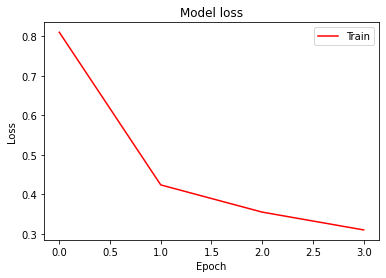

In [27]:
plt.plot(history.history['loss'], color='red')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

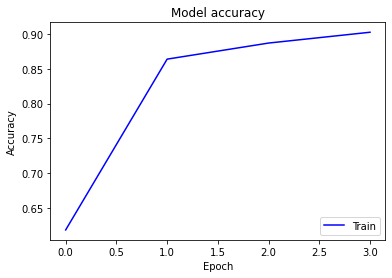

In [28]:
plt.plot(history.history['accuracy'], color='blue')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()